# Mixed input classifier
This script combines both metadata inputs for xrays, with the xray images themselves to try and detect Covid-19 from chest xrays. A training set of 2000 covid-negative and some 150 covid-positive scans was used. Note, the data is extremely unbalanced.
It should also be noted that all covid-positive scans were taken early in the patient's treatment so this classifier hopes to predict the disease early on.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import os
import ntpath

from matplotlib import pyplot as plt

from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, concatenate

from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, RMSprop
import argparse
import locale

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from keras import regularizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import load_model
from keras.callbacks import TensorBoard

import datetime

Using TensorFlow backend.


In [2]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Preparation

Here we combine the csv tables and the raw images and assign all non-covid scans as 'negative' and all covid scans as 'positive'

In [3]:
path = Path('D:\\data_science\\datasets\\coronahack')
sourcepath = path / 'source'
dfpath     = sourcepath / 'full_dataset.csv'

df1 = pd.read_csv(dfpath)
#sort alphabetically by image name - this will ensure the images and metadata are in the same order
df1 = df1.sort_values(by=['filepath'])


In [4]:
# Getting images and reshaping
#remove files not in csv (ie multiple scans of same patient)
image_folder = sourcepath / 'full-dataset'

image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        image_folder, shuffle=False, class_mode='binary',
        target_size=(256,256), batch_size=1000000)


Found 2156 images belonging to 1 classes.


In [5]:
#reclassify the images in the csv to be covid positive or negative
df1['class'] = np.where(df1['label']=='COVID-19', 1, 0)
df1=df1.drop(['label'], axis=1)
df1=df1.drop(['filepath'], axis=1)


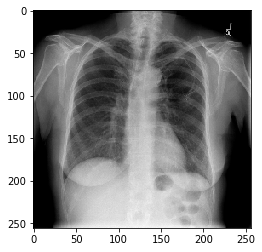

In [6]:
images, labels = next(image_generator)

#plot an image to sensecheck the data generator is feding them in the correct order
plt.imshow(images[0,:,:], cmap='gray')


## Data processing and building the network

In [10]:
from sklearn.preprocessing import MinMaxScaler

def process_structured_data(df, train, test):
    """
    Pre-processes the given dataframe by minmaxscaling the continuous features 
    """
    continuous = ["age"]
    cs = MinMaxScaler()
    trainX = cs.fit_transform(train[continuous])
    testX = cs.transform(test[continuous])
    return (trainX, testX)

def create_mlp(dim, regularizer=None):
    """Creates a simple two-layer MLP with inputs of the given dimension"""
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu", kernel_regularizer=regularizer))
    model.add(Dense(4, activation="relu", kernel_regularizer=regularizer))
    return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regularizer=None):
    """
    Creates a CNN with the given input dimension and filter numbers.
    Adapted from the function described here: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
    """
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    inputShape = (height, width, depth)
    chanDim = -1
 
    # Define the model input
    inputs = Input(shape=inputShape)
 
    # Loop over the number of filters 
    for (i, f) in enumerate(filters):
        # If this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
 
        # Create loops of CONV => RELU => BN => POOL layers
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # Final layers - flatten the volume, then Fully-Connected => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
 
    # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
 
    # Construct the CNN
    model = Model(inputs, x)
 
    # Return the CNN
    return model

## Creating a train-test split

In [11]:
from sklearn.model_selection import train_test_split
# Using train_test_split to partition the training and testing structured data attributes and images
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df1, images, test_size=0.25, random_state=57)

# Setting the labels for y as the safe column
trainY = trainAttrX["class"]
testY = testAttrX["class"]

# Process the structured data
(trainAttrX, testAttrX) = process_structured_data(df1, trainAttrX, testAttrX)

## Building the network

In [12]:
# Create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1])
cnn = create_cnn(256,256, 3)
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

In [13]:
# Add fully connected layers to end of the MLP-CNN combination
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)

model1 = Model(inputs=[mlp.input, cnn.input], outputs=x)

## Train the model

In [15]:

start = datetime.datetime.now()

LR = 1e-4
# compile the model 
opt = Adam(lr=LR, decay=LR / 200)
model1.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=opt)
 
# train the model
model1_history = model1.fit([trainAttrX, trainImagesX],
                            trainY,
                            validation_data=([testAttrX, testImagesX],testY),
                            epochs=1000,
                            batch_size=10)
model1.save ("mixed_input_classifier.h5")
end = datetime.datetime.now()
print("Time taken to run:", end-start)

Train on 1617 samples, validate on 539 samples
Epoch 1/1000
1617/1617 [==============================] - 13s 8ms/step - loss: 0.1720 - acc: 0.9481 - val_loss: 0.1773 - val_acc: 0.9518
Epoch 2/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.1635 - acc: 0.9481 - val_loss: 0.1638 - val_acc: 0.9518
Epoch 3/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.1631 - acc: 0.9481 - val_loss: 0.1654 - val_acc: 0.9518
Epoch 4/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.1642 - acc: 0.9481 - val_loss: 0.1643 - val_acc: 0.9518
Epoch 5/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.1613 - acc: 0.9481 - val_loss: 0.1745 - val_acc: 0.9518
Epoch 6/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.1491 - acc: 0.9481 - val_loss: 0.1569 - val_acc: 0.9518
Epoch 7/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.1597 - acc: 0.9481 - val_loss: 0.1502 - val_acc: 0

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0608 - acc: 0.9814 - val_loss: 0.1138 - val_acc: 0.9703
Epoch 61/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0589 - acc: 0.9833 - val_loss: 0.1487 - val_acc: 0.9647
Epoch 62/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0586 - acc: 0.9845 - val_loss: 0.1252 - val_acc: 0.9685
Epoch 63/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0609 - acc: 0.9852 - val_loss: 0.1317 - val_acc: 0.9555
Epoch 64/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0593 - acc: 0.9808 - val_loss: 0.0889 - val_acc: 0.9685
Epoch 65/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0585 - acc: 0.9839 - val_loss: 0.0983 - val_acc: 0.9666
Epoch 66/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0535 - acc: 0.9845 - val_loss: 0.1317 - val_acc: 0.9666
Epoch 67/1000
1617/1617 [=======================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0428 - acc: 0.9920 - val_loss: 0.1426 - val_acc: 0.9740
Epoch 120/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0420 - acc: 0.9920 - val_loss: 0.1196 - val_acc: 0.9740
Epoch 121/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0431 - acc: 0.9932 - val_loss: 0.1008 - val_acc: 0.9722
Epoch 122/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0403 - acc: 0.9926 - val_loss: 0.1763 - val_acc: 0.9647
Epoch 123/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0364 - acc: 0.9944 - val_loss: 0.1559 - val_acc: 0.9703
Epoch 124/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0432 - acc: 0.9938 - val_loss: 0.1146 - val_acc: 0.9777
Epoch 125/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0375 - acc: 0.9944 - val_loss: 0.1308 - val_acc: 0.9722
Epoch 126/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0290 - acc: 0.9938 - val_loss: 0.2148 - val_acc: 0.9629
Epoch 179/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0352 - acc: 0.9926 - val_loss: 0.1411 - val_acc: 0.9777
Epoch 180/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0303 - acc: 0.9951 - val_loss: 0.1336 - val_acc: 0.9777
Epoch 181/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0288 - acc: 0.9957 - val_loss: 0.1718 - val_acc: 0.9685
Epoch 182/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0342 - acc: 0.9938 - val_loss: 0.3565 - val_acc: 0.9629
Epoch 183/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0245 - acc: 0.9975 - val_loss: 0.1391 - val_acc: 0.9722
Epoch 184/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0294 - acc: 0.9951 - val_loss: 0.1161 - val_acc: 0.9740
Epoch 185/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0277 - acc: 0.9938 - val_loss: 0.1599 - val_acc: 0.9351
Epoch 238/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0216 - acc: 0.9963 - val_loss: 0.2636 - val_acc: 0.9647
Epoch 239/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0205 - acc: 0.9975 - val_loss: 0.2375 - val_acc: 0.9703
Epoch 240/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0204 - acc: 0.9981 - val_loss: 0.1893 - val_acc: 0.9722
Epoch 241/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0224 - acc: 0.9969 - val_loss: 0.1924 - val_acc: 0.9685
Epoch 242/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0251 - acc: 0.9969 - val_loss: 0.2564 - val_acc: 0.9703
Epoch 243/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0235 - acc: 0.9963 - val_loss: 0.2175 - val_acc: 0.9703
Epoch 244/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0147 - acc: 0.9994 - val_loss: 0.1812 - val_acc: 0.9777
Epoch 297/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0154 - acc: 0.9994 - val_loss: 0.2026 - val_acc: 0.9685
Epoch 298/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0160 - acc: 0.9988 - val_loss: 0.2174 - val_acc: 0.9722
Epoch 299/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0198 - acc: 0.9951 - val_loss: 0.2728 - val_acc: 0.9666
Epoch 300/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0132 - acc: 0.9994 - val_loss: 0.1844 - val_acc: 0.9740
Epoch 301/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0182 - acc: 0.9975 - val_loss: 0.1531 - val_acc: 0.9555
Epoch 302/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0171 - acc: 0.9969 - val_loss: 0.3479 - val_acc: 0.9647
Epoch 303/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0127 - acc: 0.9975 - val_loss: 0.1643 - val_acc: 0.9722
Epoch 356/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0128 - acc: 0.9975 - val_loss: 0.2193 - val_acc: 0.9685
Epoch 357/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0137 - acc: 0.9975 - val_loss: 0.1632 - val_acc: 0.9759
Epoch 358/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0143 - acc: 0.9969 - val_loss: 0.1489 - val_acc: 0.9759
Epoch 359/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0112 - acc: 0.9994 - val_loss: 0.3043 - val_acc: 0.9666
Epoch 360/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0101 - acc: 0.9994 - val_loss: 0.1307 - val_acc: 0.9740
Epoch 361/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0131 - acc: 0.9975 - val_loss: 0.1800 - val_acc: 0.9759
Epoch 362/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0133 - acc: 0.9963 - val_loss: 0.2148 - val_acc: 0.9481
Epoch 415/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0179 - acc: 0.9957 - val_loss: 0.2109 - val_acc: 0.9759
Epoch 416/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0159 - acc: 0.9963 - val_loss: 0.1947 - val_acc: 0.9573
Epoch 417/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0102 - acc: 0.9981 - val_loss: 0.3283 - val_acc: 0.9647
Epoch 418/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0109 - acc: 0.9988 - val_loss: 0.1938 - val_acc: 0.9703
Epoch 419/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0103 - acc: 0.9988 - val_loss: 0.2635 - val_acc: 0.9685
Epoch 420/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0092 - acc: 0.9994 - val_loss: 0.2658 - val_acc: 0.9685
Epoch 421/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0081 - acc: 0.9988 - val_loss: 0.1512 - val_acc: 0.9740
Epoch 474/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0100 - acc: 0.9981 - val_loss: 0.1558 - val_acc: 0.9518
Epoch 475/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0076 - acc: 0.9994 - val_loss: 0.1414 - val_acc: 0.9685
Epoch 476/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0114 - acc: 0.9975 - val_loss: 0.3342 - val_acc: 0.9685
Epoch 477/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0163 - acc: 0.9975 - val_loss: 0.8187 - val_acc: 0.6327
Epoch 478/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0136 - acc: 0.9975 - val_loss: 0.2324 - val_acc: 0.9759
Epoch 479/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0108 - acc: 0.9975 - val_loss: 0.4233 - val_acc: 0.9666
Epoch 480/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0080 - acc: 0.9988 - val_loss: 0.1356 - val_acc: 0.9740
Epoch 533/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0080 - acc: 0.9981 - val_loss: 0.2205 - val_acc: 0.9759
Epoch 534/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0081 - acc: 0.9994 - val_loss: 0.3074 - val_acc: 0.9703
Epoch 535/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0057 - acc: 0.9994 - val_loss: 0.2603 - val_acc: 0.9759
Epoch 536/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0074 - acc: 0.9988 - val_loss: 0.2183 - val_acc: 0.9759
Epoch 537/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0065 - acc: 0.9994 - val_loss: 0.1989 - val_acc: 0.9759
Epoch 538/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0110 - acc: 0.9981 - val_loss: 0.2025 - val_acc: 0.9759
Epoch 539/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0090 - acc: 0.9975 - val_loss: 0.3114 - val_acc: 0.9703
Epoch 592/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0090 - acc: 0.9975 - val_loss: 0.2695 - val_acc: 0.9722
Epoch 593/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0081 - acc: 0.9988 - val_loss: 0.1971 - val_acc: 0.9740
Epoch 594/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0059 - acc: 0.9988 - val_loss: 0.2608 - val_acc: 0.9740
Epoch 595/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0151 - acc: 0.9981 - val_loss: 0.2978 - val_acc: 0.9759
Epoch 596/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0061 - acc: 0.9988 - val_loss: 0.2641 - val_acc: 0.9759
Epoch 597/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0090 - acc: 0.9975 - val_loss: 0.1729 - val_acc: 0.9647
Epoch 598/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0107 - acc: 0.9975 - val_loss: 0.2616 - val_acc: 0.9685
Epoch 651/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0051 - acc: 0.9988 - val_loss: 0.2104 - val_acc: 0.9258
Epoch 652/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0102 - acc: 0.9963 - val_loss: 0.1331 - val_acc: 0.9685
Epoch 653/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0068 - acc: 0.9975 - val_loss: 0.1734 - val_acc: 0.9759
Epoch 654/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0080 - acc: 0.9988 - val_loss: 0.1494 - val_acc: 0.9777
Epoch 655/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1779 - val_acc: 0.9740
Epoch 656/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0058 - acc: 0.9988 - val_loss: 0.7286 - val_acc: 0.9573
Epoch 657/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0040 - acc: 0.9994 - val_loss: 0.2559 - val_acc: 0.9722
Epoch 710/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0060 - acc: 0.9988 - val_loss: 0.3082 - val_acc: 0.9685
Epoch 711/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0063 - acc: 0.9988 - val_loss: 0.3324 - val_acc: 0.9703
Epoch 712/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0060 - acc: 0.9988 - val_loss: 0.3086 - val_acc: 0.9703
Epoch 713/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0044 - acc: 0.9988 - val_loss: 0.3818 - val_acc: 0.9685
Epoch 714/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0067 - acc: 0.9988 - val_loss: 0.2847 - val_acc: 0.9740
Epoch 715/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0135 - acc: 0.9963 - val_loss: 0.4608 - val_acc: 0.9647
Epoch 716/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0040 - acc: 0.9994 - val_loss: 0.2793 - val_acc: 0.9703
Epoch 769/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.1114 - val_acc: 0.9740
Epoch 770/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0059 - acc: 0.9988 - val_loss: 0.2533 - val_acc: 0.9685
Epoch 771/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0062 - acc: 0.9981 - val_loss: 0.2658 - val_acc: 0.9573
Epoch 772/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0050 - acc: 0.9994 - val_loss: 0.3114 - val_acc: 0.9722
Epoch 773/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0068 - acc: 0.9975 - val_loss: 0.3084 - val_acc: 0.9740
Epoch 774/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0067 - acc: 0.9981 - val_loss: 0.2210 - val_acc: 0.9759
Epoch 775/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0060 - acc: 0.9988 - val_loss: 0.3613 - val_acc: 0.9685
Epoch 828/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0045 - acc: 0.9994 - val_loss: 0.2993 - val_acc: 0.9722
Epoch 829/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0049 - acc: 0.9981 - val_loss: 0.1879 - val_acc: 0.9592
Epoch 830/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0056 - acc: 0.9981 - val_loss: 0.2416 - val_acc: 0.9759
Epoch 831/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0047 - acc: 0.9994 - val_loss: 0.4187 - val_acc: 0.9647
Epoch 832/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0048 - acc: 0.9988 - val_loss: 0.2473 - val_acc: 0.9202
Epoch 833/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.5830 - val_acc: 0.9647
Epoch 834/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0058 - acc: 0.9975 - val_loss: 0.3160 - val_acc: 0.9722
Epoch 887/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0042 - acc: 0.9994 - val_loss: 0.4453 - val_acc: 0.9685
Epoch 888/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0037 - acc: 0.9994 - val_loss: 0.1776 - val_acc: 0.9740
Epoch 889/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0048 - acc: 0.9981 - val_loss: 0.4039 - val_acc: 0.9666
Epoch 890/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0115 - acc: 0.9963 - val_loss: 0.2209 - val_acc: 0.9703
Epoch 891/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0082 - acc: 0.9981 - val_loss: 0.1912 - val_acc: 0.9536
Epoch 892/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0070 - acc: 0.9981 - val_loss: 0.3012 - val_acc: 0.9740
Epoch 893/1000
1617/1617 [================

1617/1617 [==============================] - 12s 7ms/step - loss: 0.0057 - acc: 0.9981 - val_loss: 0.1733 - val_acc: 0.9685
Epoch 946/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0058 - acc: 0.9981 - val_loss: 0.5049 - val_acc: 0.9685
Epoch 947/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0037 - acc: 0.9994 - val_loss: 0.2818 - val_acc: 0.9722
Epoch 948/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0069 - acc: 0.9975 - val_loss: 0.3553 - val_acc: 0.9703
Epoch 949/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0056 - acc: 0.9988 - val_loss: 0.3102 - val_acc: 0.9722
Epoch 950/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0048 - acc: 0.9988 - val_loss: 0.2590 - val_acc: 0.9128
Epoch 951/1000
1617/1617 [==============================] - 12s 7ms/step - loss: 0.0104 - acc: 0.9969 - val_loss: 0.1928 - val_acc: 0.9722
Epoch 952/1000
1617/1617 [================

## Results

In [33]:
predictions = np.round(model1.predict([testAttrX, testImagesX])).flatten().tolist()
actuals = testY.tolist()

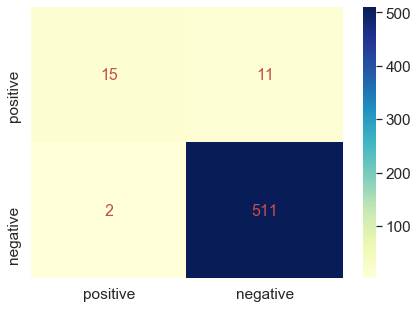

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(actuals,predictions, labels=[1,0])

df_cm = pd.DataFrame(cm, index = ['positive','negative'],
                  columns = ['positive','negative'])

plt.figure(figsize = (7,5))

sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu",annot_kws={"size": 16, "color":'r'})

The underlying data is extremely unbalanced so it is difficult to draw firm conclusions. However, the classifier does seem to do a reasonable job. Note the low false negative rate which is actually better than that for the existing throat swab lab test. That said, the popsitive cases are so low in the dataset that this is unlikely to reach statistical significance. Additional data augmentation (or ideally and expanded dataset) is necessary to make more robust conclusions.